In [1]:
import pandas as pd
import scanpy as sc
import anndata as ad
from scipy import stats
import torch.nn.functional as F
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch import Tensor
import sys
import matplotlib.pyplot as plt
loc='../training'
repi=0
torch.cuda.is_available()

True

In [2]:
cbmc_adt = pd.read_csv("../dataFiles/GSE100866/CBMC/GSE100866_CBMC_8K_13AB_10X-ADT_umi.csv")
cbmc_rna = pd.read_csv("../dataFiles/GSE100866/CBMC/GSE100866_CBMC_8K_13AB_10X-RNA_umi.csv")

In [3]:
cbmc_rna = cbmc_rna.set_index('Unnamed: 0')
cbmc_adt= cbmc_adt.set_index('Unnamed: 0')

In [4]:
adata = ad.AnnData(cbmc_rna.T)
adata.var_names = cbmc_rna.index
adata.obs_names = cbmc_rna.columns
adata.obs_names = adata.obs_names.astype(str)
adata.var_names = adata.var_names.astype(str)
adata.obsm["X_adt"] = cbmc_adt.T.values
adata.uns['protein_names'] = cbmc_adt.index.values

In [24]:
cbmc_rna.index.unique()

Index(['ERCC_ERCC-00104', 'HUMAN_A1BG', 'HUMAN_A1BG-AS1', 'HUMAN_A1CF',
       'HUMAN_A2M', 'HUMAN_A2M-AS1', 'HUMAN_A2ML1', 'HUMAN_A4GALT',
       'HUMAN_A4GNT', 'HUMAN_AAAS',
       ...
       'MOUSE_mt-Ti', 'MOUSE_mt-Tl1', 'MOUSE_mt-Tm', 'MOUSE_mt-Tp',
       'MOUSE_mt-Tq', 'MOUSE_mt-Tt', 'MOUSE_mt-Tw', 'MOUSE_n-R5s200',
       'MOUSE_n-R5s25', 'MOUSE_n-R5s31'],
      dtype='object', name='Unnamed: 0', length=36280)

In [20]:
adata.X

(8617, 1000)

In [6]:
adata.write("cbmc.h5ad")

In [7]:
adata.obs_names

Index(['CTGTTTACACCGCTAG', 'CTCTACGGTGTGGCTC', 'AGCAGCCAGGCTCATT',
       'GAATAAGAGATCCCAT', 'GTGCATAGTCATGCAT', 'TACACGACACATCCGG',
       'TCATTTGGTGTGAAAT', 'GGGCACTGTGAAGGCT', 'AACACGTCATTAACCG',
       'CACATAGCAATGCCAT',
       ...
       'GACGCGTGTAGAAAGG', 'AGCGTCGTCCCAAGTA', 'AGCGTCGAGTCAAGGC',
       'GTCGGGTAGTAGCCGA', 'GTCGGGTAGTTCGCAT', 'TTGCCGTGTAGATTAG',
       'GGCGTGTAGTGTACTC', 'CGTATGCCGTCTTCTG', 'TACACGACGCTCTTCC',
       'ACACGACGCTCTTCCG'],
      dtype='object', length=8617)

# Preporcessing

In [8]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=10)

In [9]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

## Find HVGs

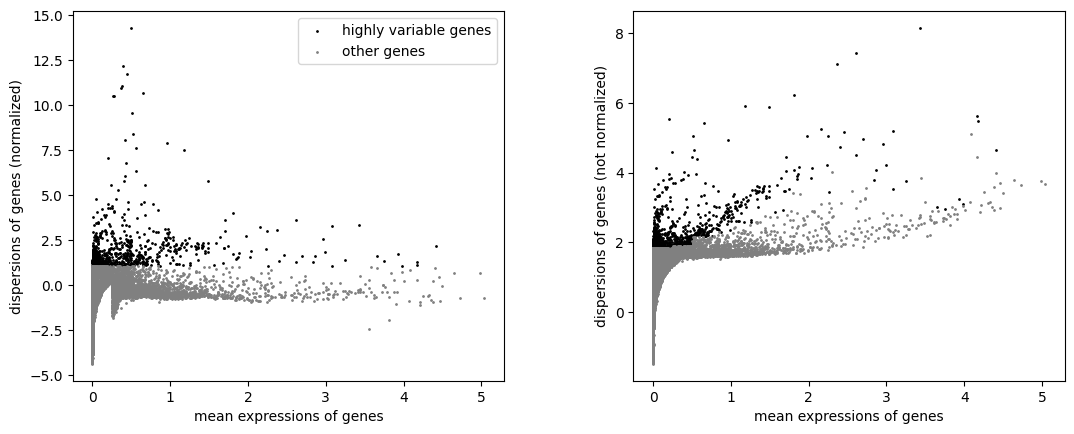

In [10]:
sc.pp.highly_variable_genes(adata, min_mean = 0.0125, max_mean = 3, min_disp = 0.5, 
                            n_top_genes = 1000)
sc.pl.highly_variable_genes(adata)

In [11]:
sc.pp.highly_variable_genes(adata, n_top_genes = 1000)
adata = adata[:, adata.var.highly_variable]

In [54]:
sc.tl.pca(adata, svd_solver='arpack')

In [55]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)


In [56]:
sc.tl.umap(adata)

In [15]:
cbmc_adt_transposed = cbmc_adt.T

cbmc_adt_transposed.index = adata.obs_names

for protein in cbmc_adt.index:
    adata.obs[protein] = cbmc_adt_transposed.loc[:, protein]

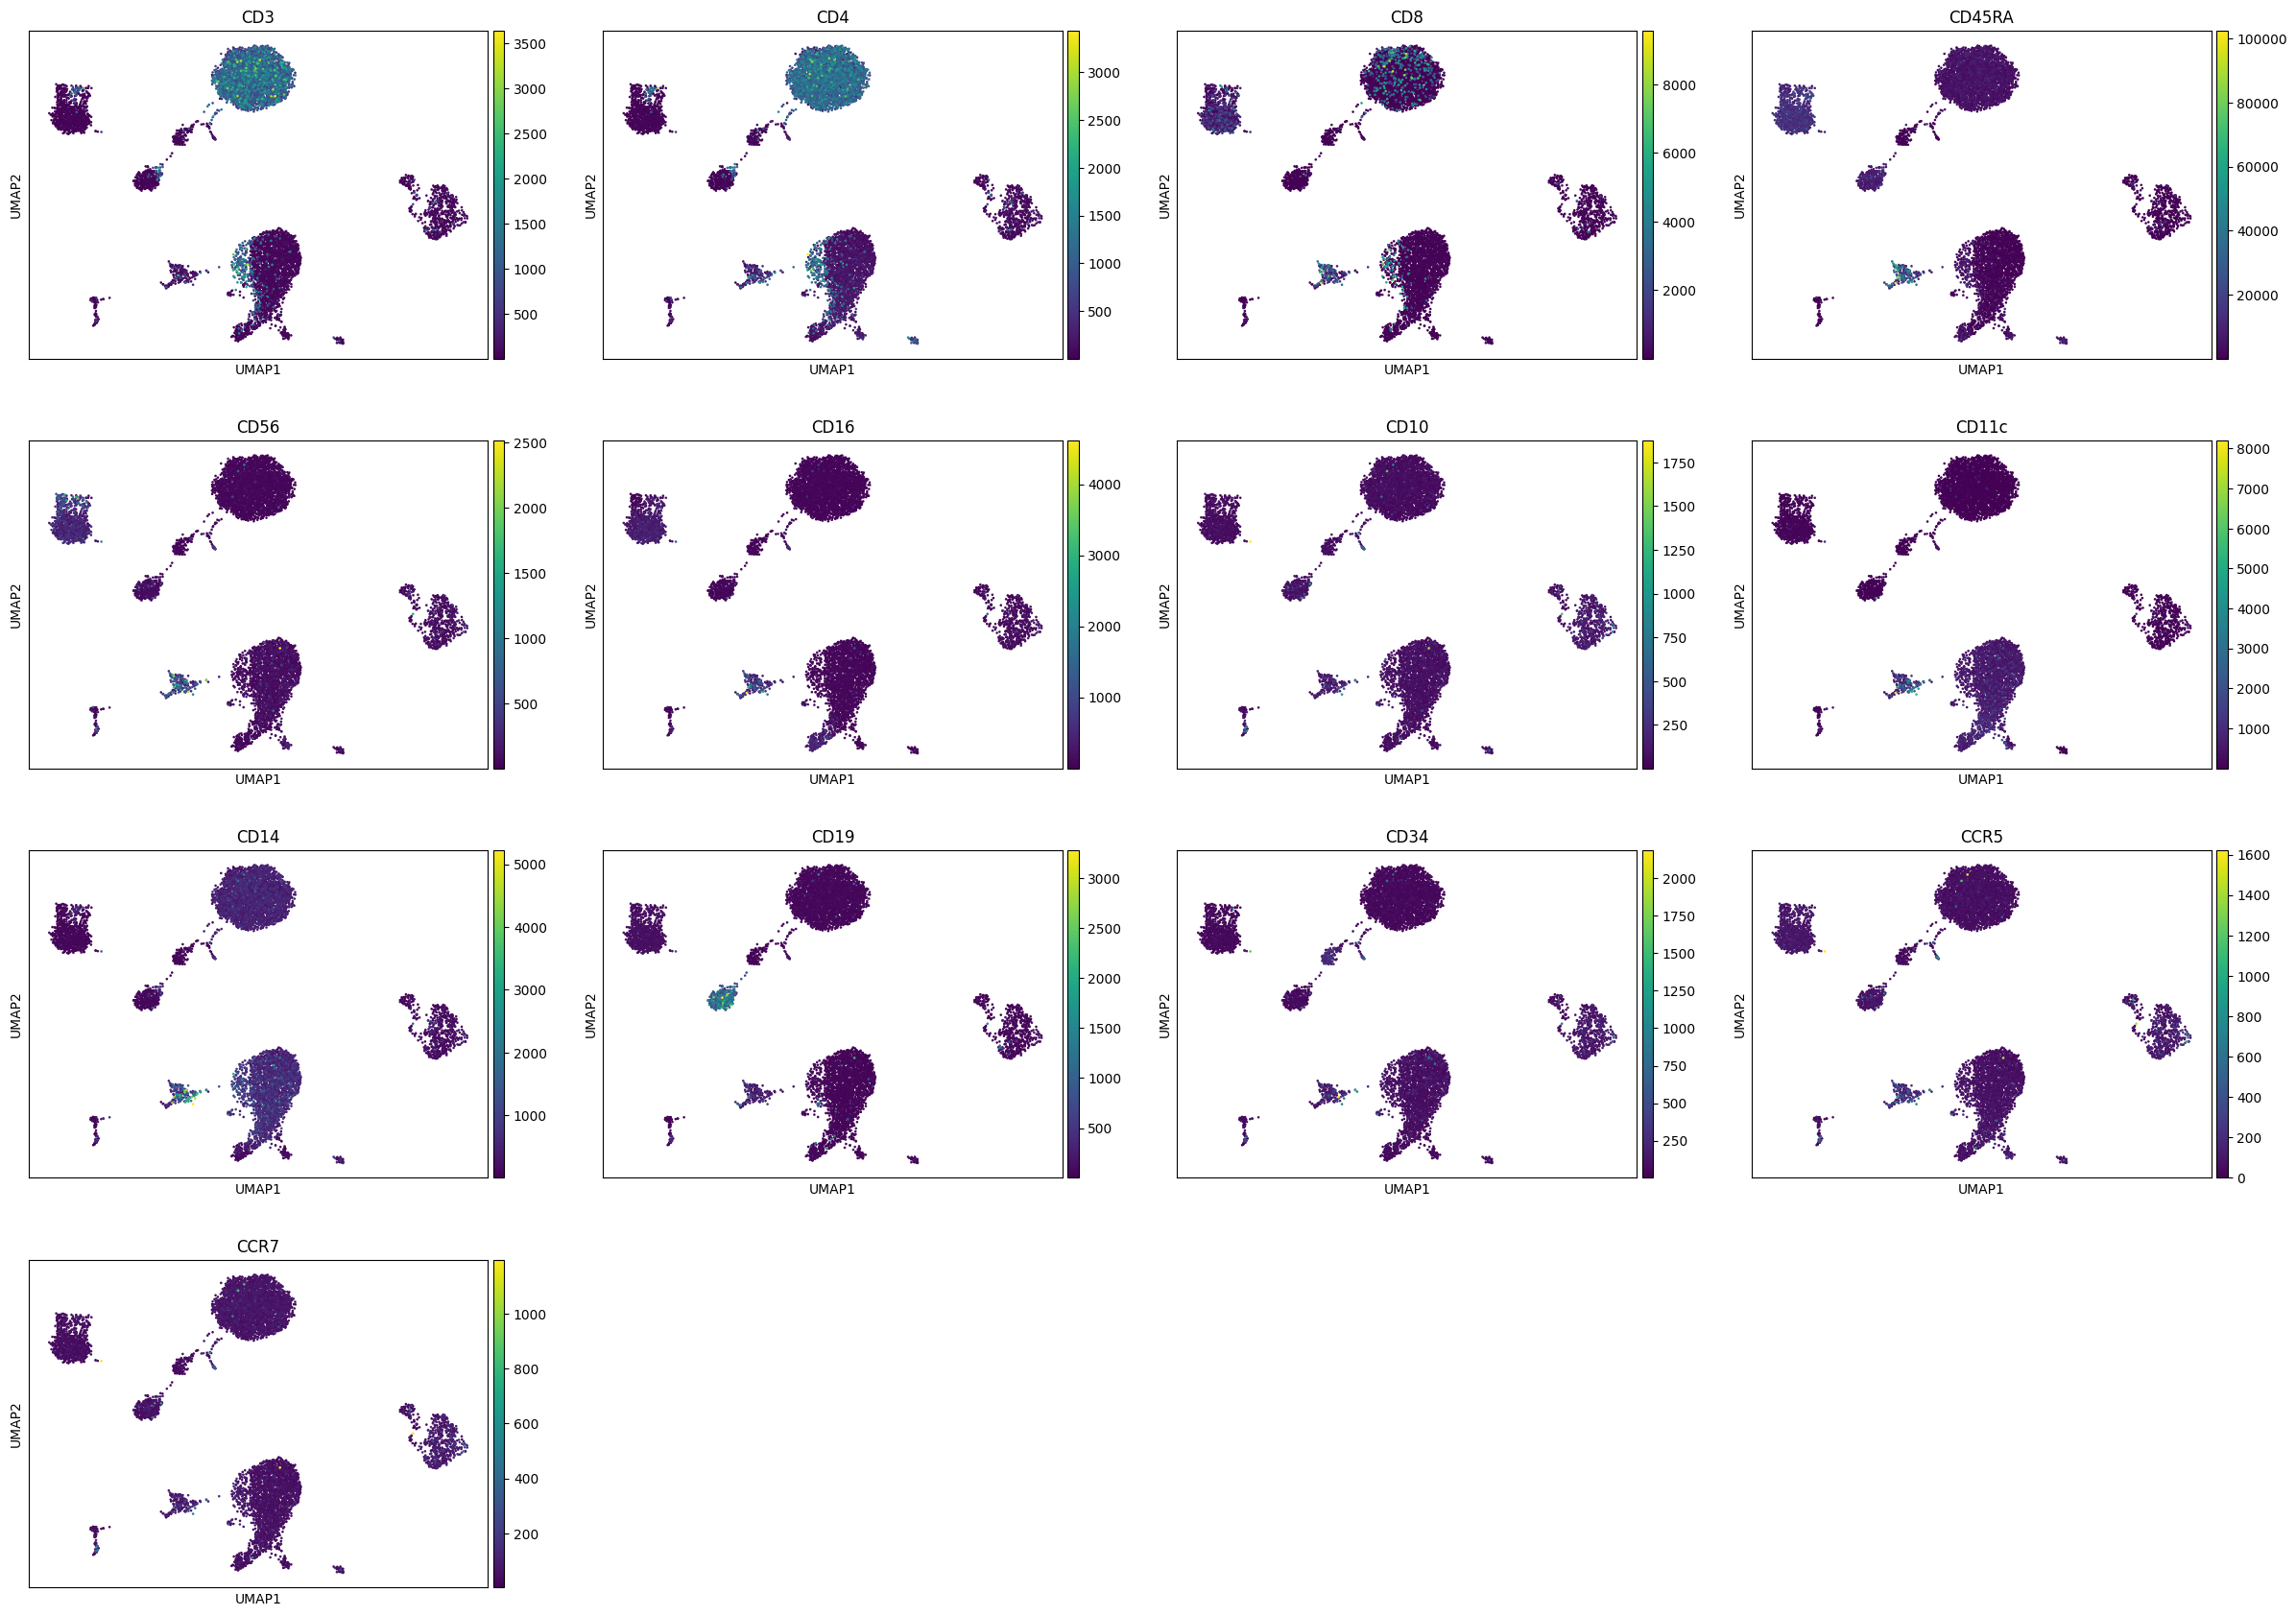

In [16]:
sc.pl.umap(adata, color=cbmc_adt.index.tolist(), )

# Normalize the Y predictors

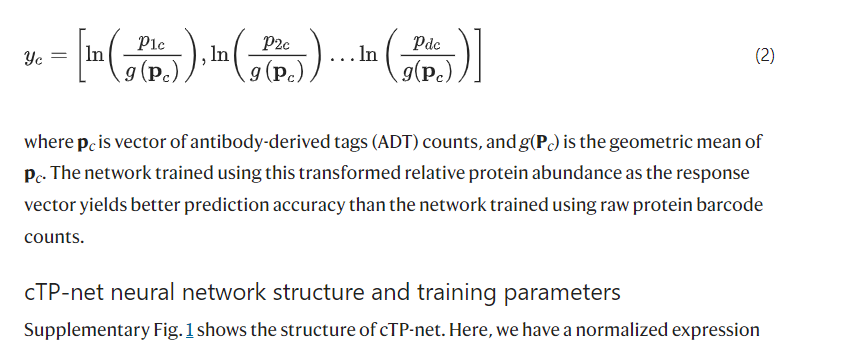

In [16]:
cbmc_rna.head()

,CTGTTTACACCGCTAG,CTCTACGGTGTGGCTC,AGCAGCCAGGCTCATT,GAATAAGAGATCCCAT,GTGCATAGTCATGCAT,TACACGACACATCCGG,TCATTTGGTGTGAAAT,GGGCACTGTGAAGGCT,AACACGTCATTAACCG,CACATAGCAATGCCAT,...,GACGCGTGTAGAAAGG,AGCGTCGTCCCAAGTA,AGCGTCGAGTCAAGGC,GTCGGGTAGTAGCCGA,GTCGGGTAGTTCGCAT,TTGCCGTGTAGATTAG,GGCGTGTAGTGTACTC,CGTATGCCGTCTTCTG,TACACGACGCTCTTCC,ACACGACGCTCTTCCG
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
ERCC_ERCC-00104,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
HUMAN_A1BG,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
HUMAN_A1BG-AS1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
HUMAN_A1CF,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
HUMAN_A2M,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
from scipy.stats import gmean

adt_counts = adata.obsm['X_adt']

# Calculate the geometric mean of the ADT counts for each cell
# We add 1 to avoid log of zero if there are any zero counts
geometric_means = gmean(adt_counts + 1, axis=1)

# Initialize a container for the normalized expression levels
normalized_adt = np.zeros(adt_counts.shape)

# Iterate over each cell to calculate the normalized expression levels
for i in range(adt_counts.shape[0]):
    # Calculate the normalized expression levels for cell i
    normalized_adt[i, :] = np.log((adt_counts[i, :] + 1) / geometric_means[i])

# If you want to store the normalized expression levels back into the AnnData object
adata.obsm['X_adt_normalized'] = normalized_adt

In [18]:
adata.obsm['X_adt_normalized'] 

array([[-0.64479311, -0.46520753, -0.41186155, ...,  0.43728988,
        -0.15049679, -0.10170663],
       [-0.84456454, -0.90283345, -0.72051189, ..., -0.43282982,
        -0.18988364, -0.52439701],
       [-0.17640346,  0.05117469, -0.54907875, ..., -0.30676528,
        -0.22186584, -0.28176398],
       ...,
       [ 0.43222529,  0.55000833, -0.26092189, ..., -0.95406907,
        -1.64721625, -0.03777834],
       [ 0.14253335,  0.03130772,  0.24261681, ..., -0.72246409,
        -0.49932053, -0.85599548],
       [-0.14902225,  0.16113268, -0.06201087, ..., -0.34969295,
        -0.75515805, -0.46747598]])

## NN Training

In [13]:
if torch.cuda.is_available():
	torch.set_default_device("cuda")

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        #self.fc1 = nn.Linear(14505, 1000)
        self.fc1 = nn.Linear(X.shape[1], 1000)
        self.fc2 = nn.Linear(1000, 256)
        self.fc3 = nn.ModuleDict({})
        for p in protein_list:
        	self.fc3[p]=nn.Linear(256, 64)
        self.fc4 = nn.ModuleDict({})
        for p in protein_list:
        	self.fc4[p]=nn.Linear(64, 1)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        outputs={}
        for p in protein_list:
        	outputs[p]=self.fc4[p](F.relu(self.fc3[p](x)))
        return outputs


gene_names = adata.var_names  # Commonly gene names are stored here
cell_ids = adata.obs_names    # Cell IDs might be stored here
protein_names = adata.obsm["X_adt_normalized"].dtype.names  # Adjust based on actual structure

# Convert to DataFrame
X_df = pd.DataFrame(adata.X, index=cell_ids, columns=gene_names)
y_df = pd.DataFrame(adata.obsm["X_adt_normalized"], index=cell_ids, columns=protein_names)

# Sample test set
X_test = X_df.sample(n=5187, random_state=4905)

# Extract test set for y
y_test = y_df.loc[X_test.index]

# Drop test set samples from training set
X = X_df.drop(X_test.index).values
y = y_df.drop(index=X_test.index).values  # Assuming you want to drop rows, not columns, based on X_test's index

X = Tensor(X).to(device = "cuda")
y = Tensor(y).to(device = "cuda")
X_test = Tensor(X_test.values).to(device = "cuda")
y_test = Tensor(y_test.values).to(device = "cuda")

available_proteins = cbmc_adt.T.columns.tolist()
print("Available proteins in ADT data:", available_proteins)
protein_list = [protein for protein in available_proteins]

net = Net()
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001,amsgrad=True, weight_decay=0.001)
n_batches=32
max_epochs=500

train_loss=pd.DataFrame(np.zeros(shape=(len(protein_list),max_epochs)),index=protein_list)
test_loss=pd.DataFrame(np.zeros(shape=(len(protein_list),max_epochs)),index=protein_list)
# Init early stop
patience=30
best_score=None
Dy=len(protein_list)
estop_counter=pd.Series(np.zeros(Dy),index=protein_list)
early_stop=pd.Series([False]*Dy,index=protein_list)

for epoch in range(max_epochs):
	if all(early_stop):
		break
	running_loss=pd.Series(np.zeros(Dy),index=protein_list)
	for i in range(int(y.shape[0]/n_batches)):
		# Local batches and labels
		local_X, local_y = X[i*n_batches:min((i+1)*n_batches,X.shape[0]-1),], y[i*n_batches:min((i+1)*n_batches,y.shape[0]-1),]
		# zero the parameter gradients
		optimizer.zero_grad()
		# forward + backward + optimize
		outputs_dict = net(local_X)
		loss=None
		loss_count=0.0
		for p in protein_list:
			notNaN=(local_y[:,protein_list.index(p):(protein_list.index(p)+1)]==local_y[:,protein_list.index(p):(protein_list.index(p)+1)])
			loss_p=criterion(outputs_dict[p][notNaN],local_y[:,protein_list.index(p):(protein_list.index(p)+1)][notNaN])
			if not torch.isnan(loss_p):
				loss_count+=1.0
				running_loss[p]+=loss_p.item()
				if loss is None:
					loss=loss_p
				else:
					loss=loss+loss_p
		loss.backward()
		optimizer.step()
		if(i==(int(y.shape[0]/n_batches)-1)):
			train_loss.iloc[:,epoch]=(running_loss / 150)
		if i % 150 == 149:    # print every mini-batches
			print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, sum(running_loss / 150)))
			running_loss=pd.Series(np.zeros(Dy),index=protein_list)
			sys.stdout.flush()
	test_outputs = net(X_test)
	test_outputs = [test_outputs[p] for p in protein_list]
	test_outputs=torch.transpose(torch.stack(test_outputs),0,1).view(X_test.shape[0],-1)
	test_loss_i=pd.Series([criterion(test_outputs[:,pi][y_test[:,pi]==y_test[:,pi]], y_test[:,pi][y_test[:,pi]==y_test[:,pi]]).item() for pi in range(Dy)],index=protein_list)
	test_loss.iloc[:,epoch]=test_loss_i
	if epoch % 10 == 9:
		f,ax=plt.subplots(figsize=(6,6))
		ax.scatter(y_test.cpu().detach().numpy(),test_outputs.cpu().detach().numpy())
		ax.plot([-2,5],[-2,5],ls='--',c='.3')
		#ax.text(3,-2,'correlation: '+str(np.corrcoef(test_outputs.detach().numpy().flatten(),y_test.detach().numpy().flatten())[1,0]))
		df = pd.DataFrame({"y_pred":test_outputs.cpu().detach().numpy().flatten(),'y_truth':y_test.cpu().detach().numpy().flatten()})
		ax.text(3,-2,'correlation: '+str(round(df.corr().values[1,0],4)))
		fig = ax.get_figure()
		fig.savefig(loc+'figure_rep'+str(repi)+'_ep'+str(epoch)+'.pdf')
		sys.stdout.flush()
		plt.close(fig)
	if epoch % 5 == 4:
		torch.save(net.state_dict(), loc+'model_rep'+str(repi)+'_ep'+str(epoch))
	# Implement early stopping
	if best_score is None:
		best_score=test_loss_i
	else:
		for p in protein_list:
			if test_loss_i[p]>(best_score[p]-0.001) and (not early_stop[p]):
				estop_counter[p]+=1
				if estop_counter[p]>=patience:
					early_stop[p]=True
			else:
				best_score[p]=test_loss_i[p]
				estop_counter[p]=0
		print(estop_counter)

print('Finished Training')


Available proteins in ADT data: ['CD3', 'CD4', 'CD8', 'CD45RA', 'CD56', 'CD16', 'CD10', 'CD11c', 'CD14', 'CD19', 'CD34', 'CCR5', 'CCR7']
CD3       0.0
CD4       0.0
CD8       0.0
CD45RA    1.0
CD56      0.0
CD16      0.0
CD10      0.0
CD11c     0.0
CD14      0.0
CD19      0.0
CD34      0.0
CCR5      0.0
CCR7      1.0
dtype: float64
CD3       1.0
CD4       0.0
CD8       0.0
CD45RA    2.0
CD56      0.0
CD16      0.0
CD10      1.0
CD11c     0.0
CD14      0.0
CD19      0.0
CD34      0.0
CCR5      1.0
CCR7      2.0
dtype: float64
CD3       2.0
CD4       0.0
CD8       1.0
CD45RA    3.0
CD56      0.0
CD16      0.0
CD10      2.0
CD11c     0.0
CD14      0.0
CD19      1.0
CD34      0.0
CCR5      2.0
CCR7      3.0
dtype: float64
CD3       3.0
CD4       1.0
CD8       2.0
CD45RA    4.0
CD56      0.0
CD16      0.0
CD10      3.0
CD11c     1.0
CD14      1.0
CD19      2.0
CD34      0.0
CCR5      3.0
CCR7      4.0
dtype: float64
CD3       4.0
CD4       2.0
CD8       3.0
CD45RA    5.0
CD56      1.0
CD16 

In [14]:
train_loss.index=['train_'+p for p in protein_list]
test_loss.index=['test_'+p for p in protein_list]
log=pd.concat([train_loss,test_loss])

<Axes: >

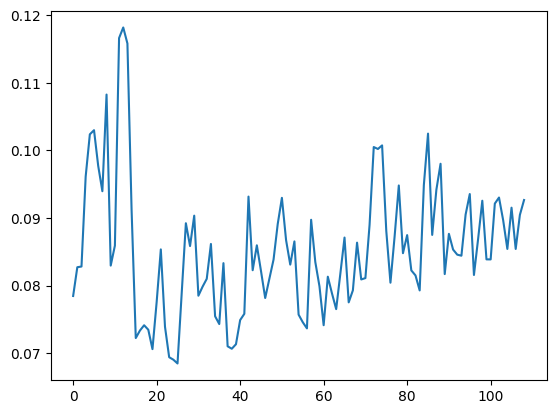

In [34]:
log.loc["test_CCR7",(log > 0).all()].plot()

## What are the correlations of the predictions in the each cell?

In [30]:
df

,y_pred,y_truth
0,2.193651,0.821701
1,2.269801,2.079481
2,-0.960043,-0.935453
3,3.529231,3.577423
4,-1.312194,-1.649220
...,...,...
67426,0.410670,0.584368
67427,-0.392050,-0.147493
67428,0.060342,-0.023879
67429,-0.184457,-0.319343


In [32]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr


correlation_coefficient, _ = pearsonr(df['y_pred'], df['y_truth'])


print(f'Overall Pearson correlation coefficient: {correlation_coefficient}')


Overall Pearson correlation coefficient: 0.941715710984884


In [48]:
df_pred = pd.DataFrame(test_outputs.cpu().detach().numpy(), columns= cbmc_adt.T.columns)
df_actual = pd.DataFrame(y_test.cpu().detach().numpy(), columns= cbmc_adt.T.columns)

In [51]:
corr_df

,Correlation
Unnamed: 0,
CD3,0.936978
CD4,0.914765
CD8,0.694681
CD45RA,0.872163
CD56,0.807829
CD16,0.860938
CD10,0.703596
CD11c,0.948128
CD14,0.899204


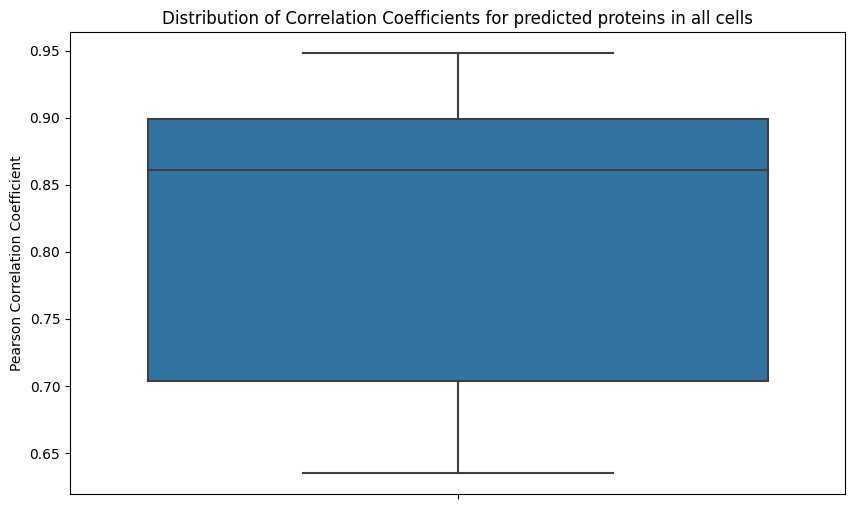

In [53]:
correlation_coefficients = []


for protein in df_pred.columns:
    corr_coeff, _ = pearsonr(df_pred[protein], df_actual[protein])
    correlation_coefficients.append(corr_coeff)


corr_df = pd.DataFrame(correlation_coefficients, columns=['Correlation'], index=df_pred.columns)

plt.figure(figsize=(10, 6))
sns.boxplot(data=corr_df, y='Correlation')
plt.xticks(rotation=90)  
plt.title('Distribution of Correlation Coefficients for predicted proteins in all cells')
plt.ylabel('Pearson Correlation Coefficient')
plt.show()

## Break Down to different cell types

### First we need to do some clustering so that can identify the different cell types so that we can do the aggregation

In [57]:
sc.tl.leiden(adata)

/mnt/home/grunew14/anaconda3/envs/dance-env/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


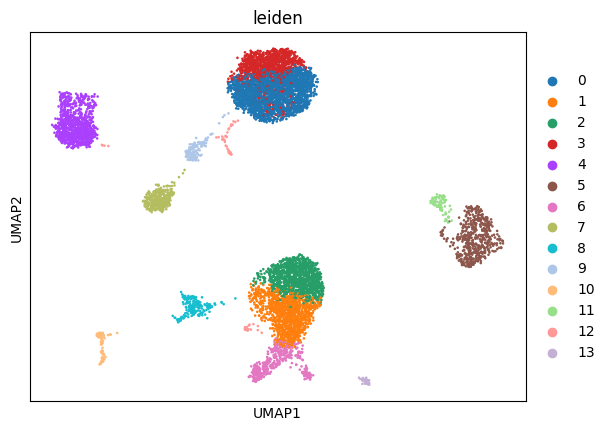

In [58]:
sc.pl.umap(adata, color='leiden')

In [59]:
X_df = pd.DataFrame(adata.X, index=cell_ids, columns=gene_names)
y_df = pd.DataFrame(adata.obsm["X_adt_normalized"], index=cell_ids, columns=protein_names)

In [67]:
y_df["Cell_type"] = list(adata.obs["leiden"].values)

In [68]:
X_test = X_df.sample(n=5187, random_state=4905)

y_test = y_df.loc[X_test.index]

In [87]:
df_pred["Cell_type"] = y_test["Cell_type"].values
df_actual["Cell_type"] = y_test["Cell_type"].values

In [88]:
len(list(adata.obs["leiden"].values))

8617

In [122]:
correlation_df = pd.DataFrame(columns=['protein','Cell_type', 'Correlation', 'p'])

In [110]:
df_pred.drop("Cell_type", axis=1).columns

Index(['CD3', 'CD4', 'CD8', 'CD45RA', 'CD56', 'CD16', 'CD10', 'CD11c', 'CD14',
       'CD19', 'CD34', 'CCR5', 'CCR7'],
      dtype='object', name='Unnamed: 0')

In [131]:

correlation_df = pd.DataFrame(columns=['protein', 'Cell_type', 'Correlation', 'p'])

rows_list = []

for protein in df_pred.drop("Cell_type", axis=1).columns:
    for cell_type in df_pred['Cell_type'].unique():  

        pred_subset = df_pred[df_pred["Cell_type"] == cell_type][protein]
        actual_subset = df_actual[df_actual["Cell_type"] == cell_type][protein]

        cora, p = pearsonr(pred_subset, actual_subset)
        
        rows_list.append({'protein': protein, 'Cell_type': cell_type, 'Correlation': cora, 'p': p})

new_rows_df = pd.DataFrame(rows_list)

correlation_df = pd.concat([correlation_df, new_rows_df], ignore_index=True)


In [155]:
correlation_df.Cell_type.unique()

array(['0', '8', '4', '12', '2', '1', '6', '7', '3', '5', '9', '11', '10',
       '13'], dtype=object)

In [159]:
correlation_df.Cell_type.unique()
correlation_df.query(f"Cell_type == '{2}'")["Correlation"]

4      0.564571
18     0.343896
32     0.185207
46     0.482081
60     0.177050
74     0.306897
88     0.349075
102    0.432357
116    0.431835
130    0.063887
144    0.238678
158    0.183540
172    0.125802
Name: Correlation, dtype: float64

{'whiskers': [<matplotlib.lines.Line2D at 0x2ab69ee31a30>,
 'caps': [<matplotlib.lines.Line2D at 0x2ab69ee31e50>,
 'boxes': [<matplotlib.lines.Line2D at 0x2ab69ee31760>],
 'medians': [<matplotlib.lines.Line2D at 0x2ab6b09d75b0>],
 'fliers': [<matplotlib.lines.Line2D at 0x2ab6b09d7670>],
 'means': []}

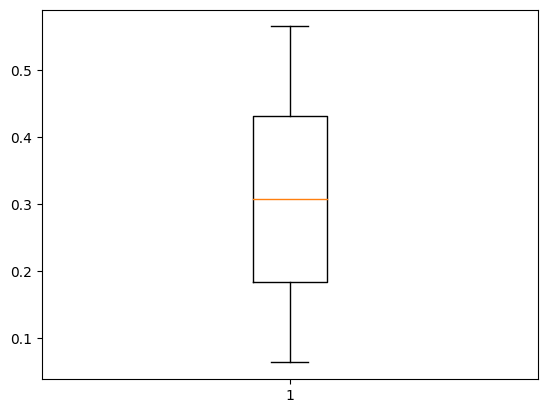

In [176]:
subset = correlation_df.query(f"Cell_type == '{2}'")["Correlation"]
plt.boxplot(subset)

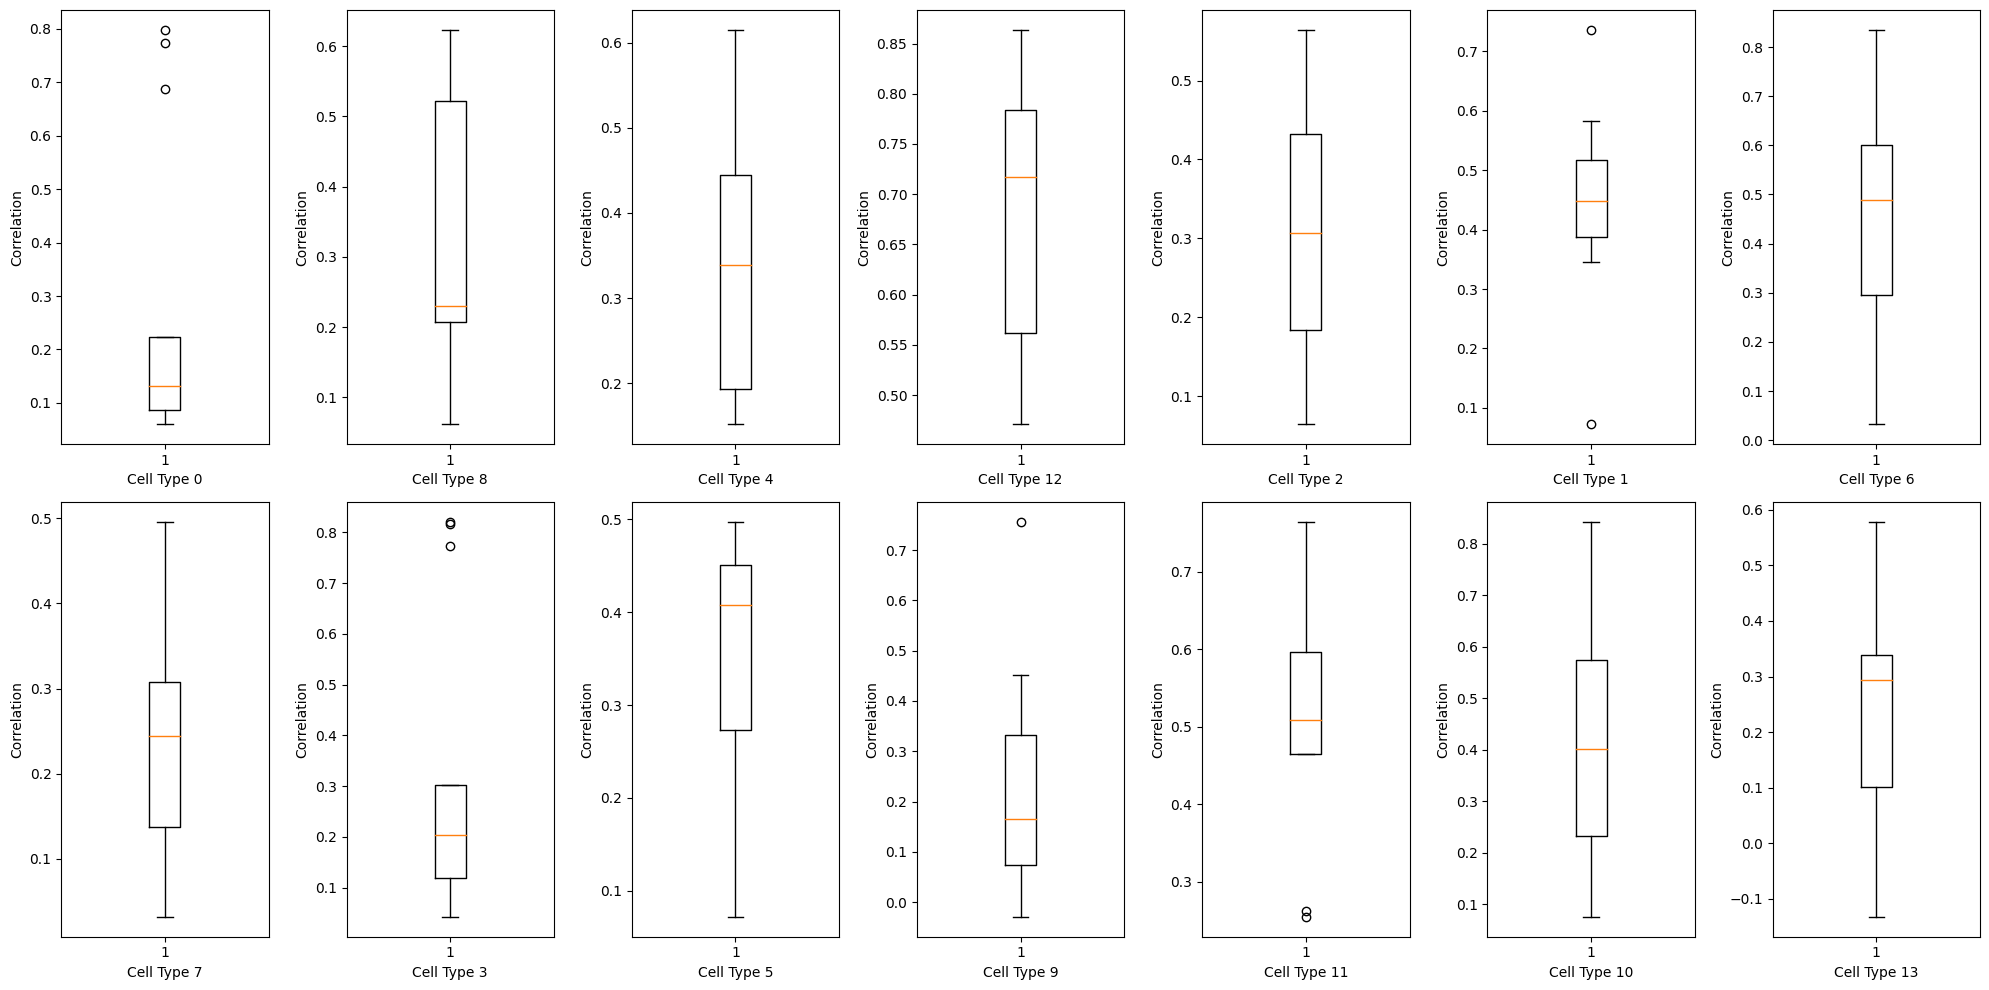

In [178]:
import matplotlib.pyplot as plt

# 

fig, axes = plt.subplots(2, 7, figsize=(20, 10))  
axes = axes.flatten()  

for i, cell_type in enumerate(correlation_df['Cell_type'].unique()):
    subset = correlation_df.query(f"Cell_type == '{cell_type}'")["Correlation"]
    axes[i].boxplot(subset)
    axes[i].set_xlabel(f"Cell Type {cell_type}")
    axes[i].set_ylabel("Correlation")  

plt.tight_layout()

plt.show()


In [141]:
subset

Series([], Name: Correlation, dtype: float64)